# Segmentação de imagens - Aula 05/08/2024

In [6]:
from pathlib import Path 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.v2 as tv_transf

In [29]:
root = Path("../data/oxford_pets")
img = np.array(Image.open(root/'images/boxer_22.jpg'))
target = np.array(Image.open(root/'annotations/trimaps/boxer_22.png'))

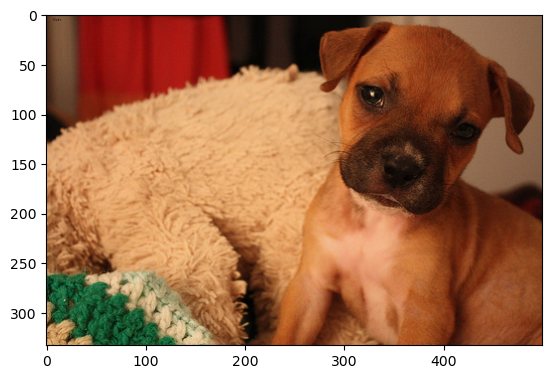

In [31]:
plt.imshow(img)

In [32]:
np.unique(target)

array([1, 2, 3], dtype=uint8)

Fundo = 2

Borda = 3

Máscara = 1

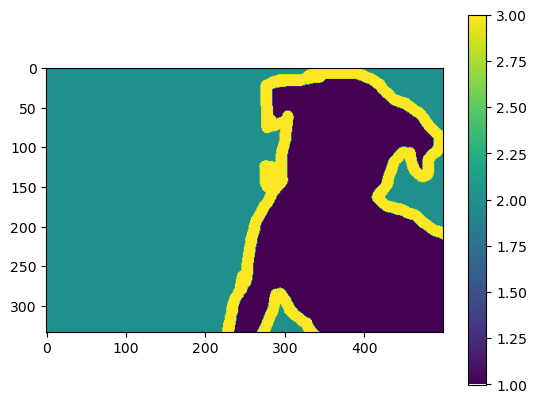

In [33]:
target_np = np.array(target)
plt.imshow(target_np)
plt.colorbar()

In [34]:
target_np.dtype

dtype('uint8')

In [63]:
def show_mask(img, target, alpha):
    img = torch.tensor(img)
    target = torch.tensor(target)
    target_bin = (target==1).unsqueeze(2).float()
    mask = (1-alpha)*img/255 + alpha*target_bin
    plt.imshow(mask)

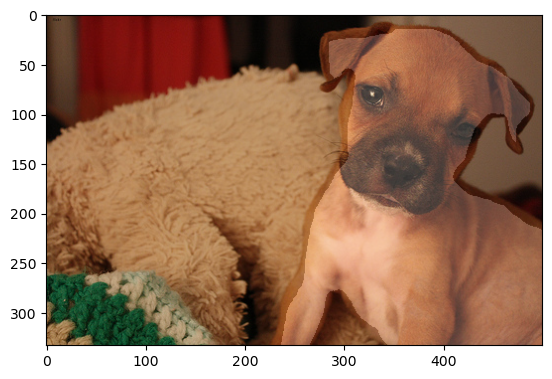

In [66]:
show_mask(img, target, 0.2)

In [64]:
target_pt = torch.tensor(target_np)

## Classe do dataset

In [98]:
class OxfordPetsSeg(Dataset):
    
    def __init__(self, root, transforms=None, ignore_val=2):
        root = Path(root)
        images_folder = root/'images'
        targets_folder = root/'annotations/trimaps'
        anns_file = root/'annotations/list.txt'
        images = []
        targets = []
        
        for line in open(anns_file).read().splitlines():
            if (line[0]!= '#'):
                name, class_id, species_id, breed_id = line.strip().split()
                images.append(images_folder/f'{name}.jpg') 
                targets.append(targets_folder/f'{name}.png') 
            
        self.images = images
        self.segs = targets 
        self.transforms = transforms
        self.ignore_val = ignore_val
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        target_or = Image.open(self.segs[idx])
        
        target_np = np.array(target_or)
        target_np[target_np==2] = 0
        target_np[target_np==3] = self.ignore_val
        
        target = Image.fromarray(target_np)
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target
    def __len__(self):
        return len(self.images)
        
ds = OxfordPetsSeg(root='../data/oxford_pets')


In [99]:
sizes = []

for file in ds.images:
    size = Image.open(file).size
    sizes.append(size)

KeyboardInterrupt: 

In [ ]:
sizes = torch.tensor(sizes)
min_s = torch.min(sizes, dim=1)
max_s = torch.max(sizes, dim=1)

C:\Users\letic\AppData\Local\Temp\ipykernel_14384\2581428633.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sizes = torch.tensor(sizes)


Distribuição do tamanho das imagens:

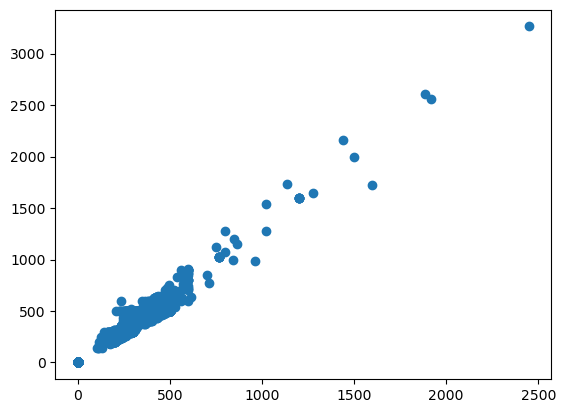

In [89]:
plt.scatter(min_s, max_s)

In [ ]:
npb = 0
npo = 0
for img, target in ds:
    target_np = np.array(target)
    npb += (target_np==0).sum()
    npo += (target_np==1).sum()
    
weights = (npo/(npb+npo), # Peso para a clsse fundo (backgorund) 
           npb/(npb+npo)) # Peso para a classe objeto
# Valores calculados de weight: (0.33, 0.66)

## Aumento de dados

Transformações

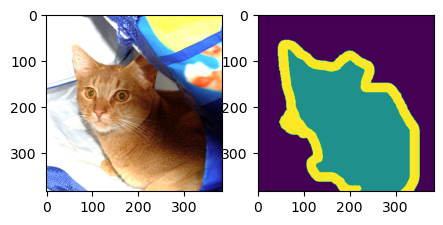

In [103]:
import  torchvision.transforms.v2 as transf
from torchvision import tv_tensors

class TransformsTrain:

    def __init__(self, resize_size=384):
    
        transforms = transf.Compose([
            transf.PILToTensor(),   
            transf.RandomResizedCrop(size=(resize_size,resize_size), scale=(0.5,1.), 
                                     ratio=(0.9,1.1), antialias=True),
            transf.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.01),
            transf.RandomHorizontalFlip(),
            # Converte imagens para float32 e rótulos para int64
            transf.ToDtype({tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.int64}),
            # Transformação comentada para facilitar a visualização
            #transf.Normalize(mean=(122.7, 114.6, 100.9), std=(59.2, 58.4, 59.0))
        ])

        self.transforms = transforms

    def __call__(self, img, target):
        # Convertemos os tensores para os tipos Image e Mask para que as transformações 
        # tratem adequadamente as duas imagens. Por exemplo, não faz sentido modificar
        # o brilho da imagem de rótulo
        img = tv_tensors.Image(img)
        target = tv_tensors.Mask(target)
        img, target = self.transforms(img, target)
        # O atributo .data da classe Image possui o tensor que foi transformado
        img = img.data
        target = target.data
        # Remoção da dimensão de canal do target, pois as funções de loss esperam
        # um target de tamanho batch_size x altura x largura
        target = target.squeeze()
        return img, target
    
transforms = TransformsTrain()
img, target = transforms(*ds[0])

fig, axs = plt.subplots(1, 2, figsize=(5,3))
axs[0].imshow(img.permute(1, 2, 0)/255)
axs[1].imshow(target)

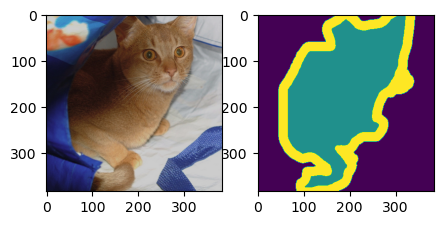

In [106]:
class TransformsEval:
    
    def __init__(self):
        transforms = tv_transf.Compose([
            tv_transf.PILToTensor(),
            tv_transf.Resize(size=(384,384)),
            tv_transf.ToDtype({tv_tensors.Image:torch.float, tv_tensors.Mask:torch.int64})
        ])
        
        self.transforms = transforms
        
    
    def __call__(self, img, target):
        img = tv_tensors.Image(img)
        target = tv_tensors.Mask(target)
        img, target = self.transforms(img, target)
        
        img = img.data
        target = target.data
        
        return img, target
    
transforms = TransformsEval()
img, target = transforms(*ds[0])

fig, axs = plt.subplots(1, 2, figsize=(5,3))
axs[0].imshow(img.permute(1, 2, 0)/255)
axs[1].imshow(target)